In [84]:
import lalsimulation as ls
import lal
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import math
import time
from scipy.optimize import minimize


In [81]:
def compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant):
    
    # These have to be set to 0 by definition
    inc, phiC  = 0., 0.
    
    # Generate the modes hlm 
    hlms = ls.SimInspiralChooseFDModes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, f_low, phiC, distance, inc, None, approximant)
    
    return hlms    

In [3]:
def match_HM_k_opt_LAL(hlm1_FD,hlm2_FD,iota,phi,kappa,deltaF, Sn, zpfact=2):
    # Check if the two waveform have the same size
    assert(len(hlm1_FD.fdata.data) == len(hlm1_FD.fdata.data))

    wf1_FD = compute_hFDNR_LAL(hlm1_FD,iota, phi, kappa)[:-1]

    # Compute the norm of the true waveform
    norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))
    

    # Define the match as a function of phi. This match is analytically optimized over kappa
    def match_HM_phi_kopt(x):
        try:
            # Unpacking for multiD mimimization
            len(x)
            x = x[0]
        except:
            pass
        
        hp_ROM, hc_ROM = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm2_FD,iota,x)
        hp_ROM, hc_ROM = hp_ROM.data.data[:-1], hc_ROM.data.data[:-1]
        n = len(hp_ROM)
        A_p = np.sqrt(np.sum(np.abs(hp_ROM)**2/Sn))
        A_c = np.sqrt(np.sum(np.abs(hc_ROM)**2/Sn))

        if A_c/A_p>1e-8: #if we really have two non zero polarizations
            Ipc = np.real(np.dot(np.conjugate(hp_ROM),hc_ROM/Sn))
            integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
            rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
            integrand = np.conjugate(hc_ROM)*wf1_FD/Sn
            rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

            alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
            kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

            gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
            sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
            beta = (A_p**2+A_c**2)/2.

            #print A_p,A_c,Ipc,gamma,sigma0,beta
            num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
            den = norm1*np.sqrt(beta**2-gamma**2)
            overlap = num/den
        else:
            integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
            ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
            maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
            overlap = maxifftterm/(norm1*A_p)

        return -overlap

    # Numerically optimize over phi
    # First find the minimum in a discrete manner
    phi_ini_guess = np.linspace(0.,2*np.pi,num=40)
    discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
    discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
    res =minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
    return -match_HM_phi_kopt(res.x)


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)


In [4]:
def get_hyb_dummy(hlm_dummy, hlm_1, hlm_2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
        
    a1 = np.abs(hlm_1)
    phi1 = np.unwrap(np.angle(hlm_1))   
    
    a2 = np.abs(hlm_2)
    phi2 = np.unwrap(np.angle(hlm_2))

    a_hyb = a1*(1-lam) + a2*(lam)
    phi_hyb = phi1*(1-lam) + phi2*(lam)
    
    hlm_hyb =  a_hyb * np.exp(1.j * phi_hyb)
    
    # set dummy (2,2) data to Hybrid waveform
    freq_size = len(hlm_dummy.next.next.next.next.next.next.next.next.mode.data.data)
    zero_pos = np.where(hlm_dummy.fdata.data==0)[0][0]

    # Make sure the data extends to both sides of frequency space
    hlm_hyb_extended = np.zeros(freq_size, dtype=complex)
    hlm_hyb_extended[:zero_pos+1] = 0

    hlm_hyb_extended[zero_pos:] = hlm_hyb

    hlm_dummy.next.next.next.next.next.next.next.next.mode.data.data = hlm_hyb_extended
    
    return hlm_dummy

In [5]:
def get_LIGO_psd(f_low,deltaF,len_wf):

    # Define the frequency series where to put the PSD
    epoch = lal.LIGOTimeGPS(0, 0)

    Sn = lal.CreateREAL8FrequencySeries("psd",epoch,0.,deltaF,lal.StrainUnit,len_wf)

    # Compute the PSD from the given f_low
    ls.SimNoisePSDaLIGOZeroDetHighPowerGWINC(Sn,f_low)
    
    Sn.data.data[0 : int(f_low/deltaF)] = Sn.data.data[int(f_low/deltaF)]
    Sn.data.data[-1] = Sn.data.data[-2]
    
    return Sn

In [6]:
def compute_hFDNR_LAL(hlm_FD,theta,phi,kappa):
    hpFD,hcFD = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm_FD,theta,np.pi/2.-phi)
    return np.cos(kappa)*hpFD.data.data+np.sin(kappa)*hcFD.data.data

In [7]:
deltaF, f_low, f_max = 1./32., 20., 2048.
Sn = get_LIGO_psd(f_low,deltaF,int(f_max/deltaF))

## Generate Waveforms

In [8]:
chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
deltaF, f_low, f_max = 1./32., 20., 2048.
iota, phi_c, kappa = 0. , 0., 0.
phiRef = 0.
distance = 1e6*lal.PC_SI
fRef_in = f_low

chi1_z = 0.
chi2_z = 0.

freq_range = np.linspace(0, f_max, int(f_max/deltaF))

theta, phi, psi = np.pi/3, np.pi/3, np.pi/3

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

kappa = -1j* np.log((Fplus + 1j*Fcross) / (np.sqrt(Fplus**2 + Fcross**2)))


In [9]:
# Generate Waveforms with default:
# M = 50.*lal.MSUN_SI
# q = 3.1
def generate_waveforms(M = 50.*lal.MSUN_SI, q=3.1):
    m1, m2 = q*M/(1.+q), M/(1.+q)
    hlm_dummy_xas = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)
    hlm_dummy_d = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)

    freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
    zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

    # IMRPhenomXAS
    approximant = ls.IMRPhenomXAS
    hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
    hlm_xas = hplus.data.data + 1j*hcross.data.data

    # set dummy (2,2) data to IMRPhenomD waveform
    l = hlm_dummy_xas.next.next.next.next.next.next.next.next.l
    m = hlm_dummy_xas.next.next.next.next.next.next.next.next.m

    freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
    zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

    hlm_xas_extended = np.zeros(freq_size, dtype=complex)
    hlm_xas_extended[:zero_pos+1] = 0

    hlm_xas_extended[zero_pos:] = hlm_xas

    hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data = hlm_xas_extended


    # IMRPhenomD
    approximant = ls.IMRPhenomD
    hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
    hlm_d = hplus.data.data + 1j*hcross.data.data
    hlm_d = -hlm_d # Flipped to account for convention

    # # set dummy (2,2) data to IMRPhenomXAS waveform
    # l = hlm_dummy_d.next.next.next.next.next.next.next.next.l
    # m = hlm_dummy_d.next.next.next.next.next.next.next.next.m

    # freq_size = len(hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data)
    # zero_pos = np.where(hlm_dummy_d.fdata.data==0)[0][0]

    # hlm_d_extended = np.zeros(freq_size, dtype=complex)
    # hlm_d_extended[:zero_pos+1] = 0
    # hlm_d_extended[zero_pos:] = hlm_d

    # hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data = hlm_d_extended
    hlm_dummy_d = hlm_d

    hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
        

    return hlm_xas, hlm_dummy_xas, hlm_d, hlm_dummy_d, hlm_dummy_test



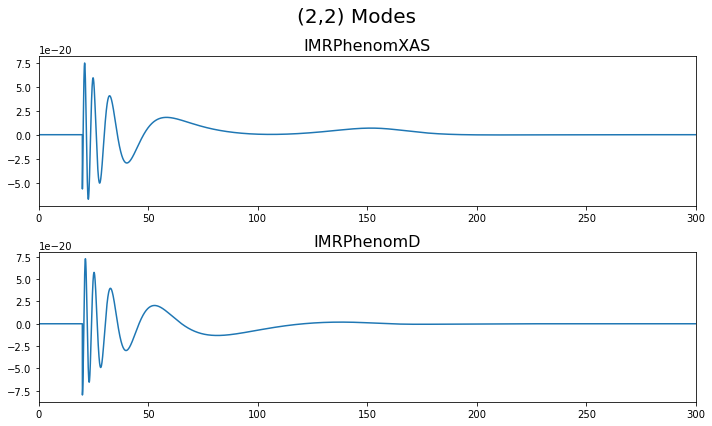

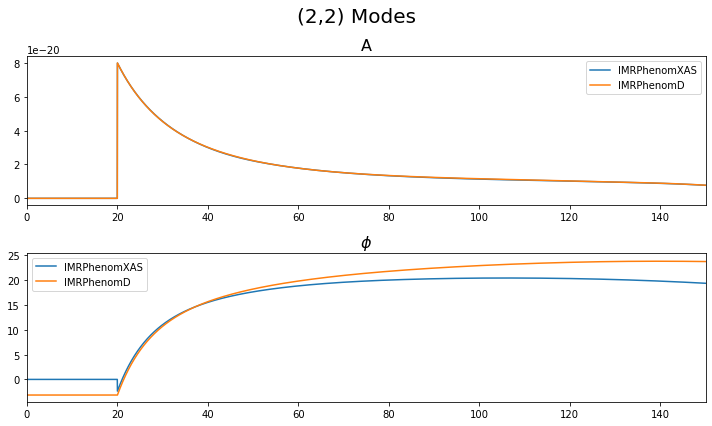

In [29]:
hlm_xas, hlm_dummy_xas, hlm_d, hlm_dummy_d, hlm_dummy_test= generate_waveforms(M = 100.*lal.MSUN_SI, q=3.1)

f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,6)) 
ax1.plot(freq_range, np.real(hlm_xas)[:-1])
ax1.set_xlim(0, 300)
ax1.set_title('IMRPhenomXAS', fontsize=16)


ax2.plot(freq_range, np.real(hlm_d)[:-1])
ax2.set_xlim(0, 300)
ax2.set_title('IMRPhenomD', fontsize=16)

plt.suptitle('(2,2) Modes', fontsize=20)

plt.tight_layout()
plt.show()

a1 = np.abs(hlm_xas)[:-1]
phi1 = np.unwrap(np.angle(hlm_xas))[:-1]

a2 = np.abs(hlm_d)[:-1]
phi2 = np.unwrap(np.angle(hlm_d))[:-1]

f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,6)) 

ax1.plot(freq_range, a1, label='IMRPhenomXAS')
ax1.plot(freq_range, a2, label='IMRPhenomD')
ax1.set_xlim(0,150)
ax1.set_title('A', fontsize=16)

ax1.legend()

ax2.plot(freq_range, phi1, label='IMRPhenomXAS')
ax2.plot(freq_range, phi2, label='IMRPhenomD')
ax2.set_xlim(0,150)
ax2.set_title('$\phi$', fontsize=16)
ax2.legend()

plt.suptitle('(2,2) Modes', fontsize=20)

plt.tight_layout()
plt.show()

# max_lam = 1j*(1/(phi1-phi2)) + a1*(1/(a1-a2))


In [44]:
print(f"{a1[100]:.30f}")
phi1

0.000000000000000000000000000000


array([0.        , 0.        , 0.        , ..., 6.28318531, 6.28318531,
       6.28318531])

In [46]:
max_lam = np.sum(1j/(phi1-phi2)) / (f_max - f_low)
max_lam

-3.6726343976090248j

## Create dummy waveform containers

In [10]:
# hlm_dummy_xas = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)
# hlm_dummy_d = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)

# print(type(hlm_dummy_d))

# freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
# zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]


In [11]:
# # IMRPhenomXAS
# approximant = ls.IMRPhenomXAS
# hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
# hlm_xas = hplus.data.data + 1j*hcross.data.data

# # set dummy (2,2) data to IMRPhenomD waveform
# l = hlm_dummy_xas.next.next.next.next.next.next.next.next.l
# m = hlm_dummy_xas.next.next.next.next.next.next.next.next.m
# print(f"overwriting ({l}, {m}) mode")

# freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
# zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

# hlm_xas_extended = np.zeros(freq_size, dtype=complex)
# hlm_xas_extended[:zero_pos+1] = 0

# hlm_xas_extended[zero_pos:] = hlm_xas

# hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data = hlm_xas_extended


In [12]:
# # IMRPhenomD
# approximant = ls.IMRPhenomD
# hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
# hlm_d = hplus.data.data + 1j*hcross.data.data
# hlm_d = -hlm_d # Flipped to account for convention

# # set dummy (2,2) data to IMRPhenomXAS waveform
# l = hlm_dummy_d.next.next.next.next.next.next.next.next.l
# m = hlm_dummy_d.next.next.next.next.next.next.next.next.m
# print(f"overwriting ({l}, {m}) mode")

# freq_size = len(hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data)
# zero_pos = np.where(hlm_dummy_d.fdata.data==0)[0][0]

# hlm_d_extended = np.zeros(freq_size, dtype=complex)
# hlm_d_extended[:zero_pos+1] = 0
# hlm_d_extended[zero_pos:] = hlm_d

# hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data = hlm_d_extended


# Compute Faithfulness for Hybrid Waveforms (upto monotonic)

In [13]:
# def generate_xas(m1_current, m2_current):
#     approximant = ls.IMRPhenomXAS
#     hplus, hcross = ls.SimInspiralChooseFDWaveform(m1_current, m2_current, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
#     hlm_xas = hplus.data.data + 1j*hcross.data.data

#     # set dummy (2,2) data to IMRPhenomD waveform
#     l = hlm_dummy_xas.next.next.next.next.next.next.next.next.l
#     m = hlm_dummy_xas.next.next.next.next.next.next.next.next.m

#     freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
#     zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

#     hlm_xas_extended = np.zeros(freq_size, dtype=complex)
#     hlm_xas_extended[:zero_pos+1] = 0

#     hlm_xas_extended[zero_pos:] = hlm_xas

#     hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data = hlm_xas_extended
#     return hlm_xas, hlm_dummy_xas

In [14]:
# def generate_d(m1_current, m2_current):
#     approximant = ls.IMRPhenomD
#     hplus, hcross = ls.SimInspiralChooseFDWaveform(m1_current, m2_current, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
#     hlm_d = hplus.data.data + 1j*hcross.data.data
#     hlm_d = -hlm_d # Flipped to account for convention
#     return hlm_d


## First attempt (discrete lambdas, constant q)

In [22]:
n_lams = 10
n_Ms = 10
Ms = np.linspace(10, 100, n_Ms)*lal.MSUN_SI
q = 3.1
max_lam_for_Ms = np.zeros(n_Ms)
min_faith_for_Ms = np.zeros(n_Ms)

lams = np.linspace(0.0, 1.0, n_lams)


for j in range(n_Ms):
    start = time.time()
    print(f"Total Mass: {Ms[j]:.2e}")

    hlm_xas, hlm_dummy_xas, hlm_d, hlm_dummy_d, hlm_dummy_test= generate_waveforms(M = Ms[j], q=q)
    matches = np.zeros(n_lams)
    
    for i in range(n_lams):
        hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lams[i])
        match =  match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
        matches[i] = match
        max_lam_for_Ms[j] = lams[i]
        min_faith_for_Ms[j] = matches[i]
        
        if (i > 0 and matches[i-1] < match):
            max_lam_for_Ms[j] = lams[i-1]
            min_faith_for_Ms[j] = matches[i-1]
            break
    end = time.time()
    print(f"Computation completed in {end-start :.2f} s")
    print(matches)
    print()
    
    

Total Mass: 1.99e+31
Computation completed in 19.22 s
[1.         0.99993679 0.99974421 0.99985004 0.         0.
 0.         0.         0.         0.        ]

Total Mass: 3.98e+31
Computation completed in 45.16 s
[1.         0.99982072 0.99970873 0.99947638 0.99930618 0.99917828
 0.99891819 0.99868305 0.99817408 0.99791478]

Total Mass: 5.97e+31
Computation completed in 41.56 s
[1.         0.99969358 0.99939623 0.99890612 0.99865133 0.99856631
 0.99821478 0.99786923 0.99713548 0.99646038]

Total Mass: 7.95e+31
Computation completed in 43.06 s
[1.         0.99961028 0.99895714 0.99828421 0.99794758 0.99783976
 0.99769947 0.99716803 0.99620521 0.99531614]

Total Mass: 9.94e+31
Computation completed in 27.66 s
[1.         0.99948891 0.99845743 0.99748432 0.99709554 0.99718885
 0.         0.         0.         0.        ]

Total Mass: 1.19e+32
Computation completed in 27.16 s
[1.         0.99933848 0.99792643 0.99660478 0.9962114  0.99647088
 0.         0.         0.         0.        ]



In [23]:
for i in range(n_Ms):
    print(f"Monotonic range on lambda for M = {(Ms[i]/lal.MSUN_SI)} M_sun = [0, {max_lam_for_Ms[i]:.2e}], with min Faithfulness = {min_faith_for_Ms[i]:.5f}")

Monotonic range on lambda for M = 10.0 M_sun = [0, 2.22e-01], with min Faithfulness = 0.99974
Monotonic range on lambda for M = 20.0 M_sun = [0, 1.00e+00], with min Faithfulness = 0.99791
Monotonic range on lambda for M = 30.0 M_sun = [0, 1.00e+00], with min Faithfulness = 0.99646
Monotonic range on lambda for M = 40.0 M_sun = [0, 1.00e+00], with min Faithfulness = 0.99532
Monotonic range on lambda for M = 50.0 M_sun = [0, 4.44e-01], with min Faithfulness = 0.99710
Monotonic range on lambda for M = 60.0 M_sun = [0, 4.44e-01], with min Faithfulness = 0.99621
Monotonic range on lambda for M = 70.0 M_sun = [0, 4.44e-01], with min Faithfulness = 0.99531
Monotonic range on lambda for M = 80.0 M_sun = [0, 4.44e-01], with min Faithfulness = 0.99433
Monotonic range on lambda for M = 90.0 M_sun = [0, 4.44e-01], with min Faithfulness = 0.99337
Monotonic range on lambda for M = 100.0 M_sun = [0, 4.44e-01], with min Faithfulness = 0.99241


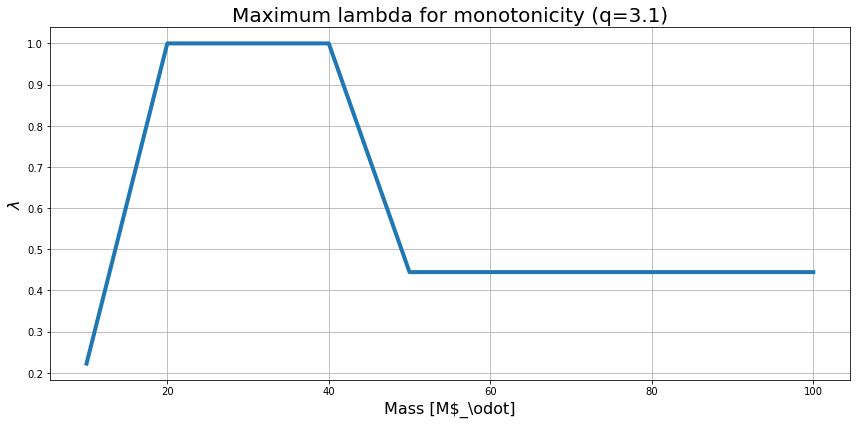

In [26]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(Ms/lal.MSUN_SI, max_lam_for_Ms, lw=lw)

plt.xlabel('Mass [M$_\odot]', fontsize=16)
plt.ylabel('$\lambda$', fontsize=16)

plt.title('Maximum lambda for monotonicity (q=3.1)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

## Second Attempt: search for min lambda

In [34]:
n_Ms = 10
Ms = np.linspace(10, 100, n_Ms)*lal.MSUN_SI
q = 3.1
max_lam_for_Ms = np.zeros(n_Ms)
min_faith_for_Ms = np.zeros(n_Ms)

n_lams = 10
lams = np.linspace(0.0, 1.0, n_lams)

max_recursion = 3


for j in range(n_Ms):
    start = time.time()
    print(f"Total Mass: {Ms[j]:.2e}")
    hlm_xas, hlm_dummy_xas, hlm_d, hlm_dummy_d, hlm_dummy_test= generate_waveforms(M = Ms[j], q=q)
    lams = np.linspace(0.0, 1.0, n_lams)
    matches = np.zeros(n_lams)

    recursion_level=0
    turning_pt_found=False
    i = 0
    # find the turning point
    while (not turning_pt_found and i < n_lams):
        hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lams[i])
        match =  match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
        matches[i] = match
        max_lam_for_Ms[j] = lams[i]
        min_faith_for_Ms[j] = matches[i]

        if (i > 0 and matches[i-1] < match):
            # print(matches)
            if (recursion_level < max_recursion):
                min_lam = lams[i-1] - 0.1*lams[i-1]
                max_lam = lams[i] + 0.1*lams[i]
                print(f"turning point crossed with faithfulness {match:.3e}, entering recursive search with level {recursion_level}, lam = [{min_lam}, {max_lam}]")

                lams = np.linspace(min_lam, max_lam, n_lams)
                matches = np.zeros(n_lams)
                recursion_level += 1
                i = -1
                
            else:
                min_faith_for_Ms[j] = (matches[i-1] + matches[i])/2
                max_lam_for_Ms[j] = (lams[i-1]+lams[i])/2
                turning_pt_found = True
                
        i +=1
            
    end = time.time()
    print(f"Computation completed in {end-start :.2f} s")
    print(f"Max lambda: {max_lam_for_Ms[j]}")
    print(f"Min faithfulness: {min_faith_for_Ms[j]}")
    print(matches)
    print()
    
    

Total Mass: 1.99e+31
turning point crossed with faithfulness 9.999e-01, entering recursive search with level 0, lam = [0.19999999999999998, 0.36666666666666664]
turning point crossed with faithfulness 9.998e-01, entering recursive search with level 1, lam = [0.19666666666666666, 0.2607407407407407]
turning point crossed with faithfulness 9.998e-01, entering recursive search with level 2, lam = [0.2026296296296296, 0.25548971193415637]
Computation completed in 76.35 s
Max lambda: 0.22318632830361224
Min faithfulness: 0.9997683739227112
[0.99989404 0.99985771 0.99981403 0.999763   0.99977375 0.
 0.         0.         0.         0.        ]

Total Mass: 3.98e+31
Computation completed in 43.09 s
Max lambda: 1.0
Min faithfulness: 0.9979147844512014
[1.         0.99982072 0.99970873 0.99947638 0.99930618 0.99917828
 0.99891819 0.99868305 0.99817408 0.99791478]

Total Mass: 5.97e+31
Computation completed in 42.57 s
Max lambda: 1.0
Min faithfulness: 0.99646038409648
[1.         0.99969358 0.99

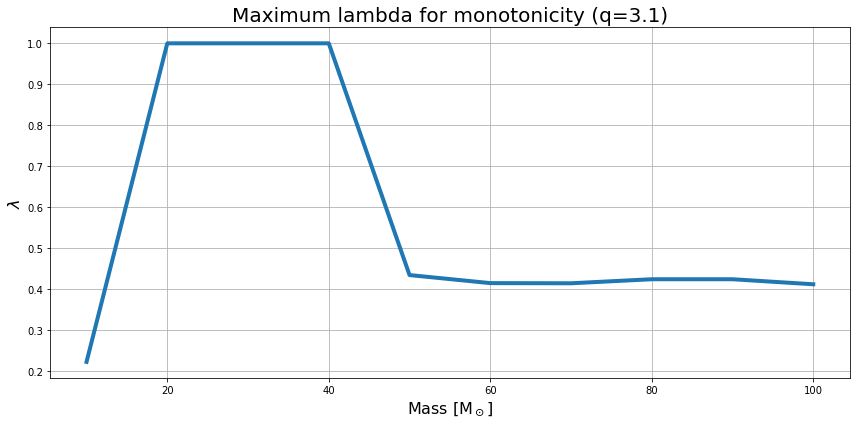

In [35]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(Ms/lal.MSUN_SI, max_lam_for_Ms, lw=lw)     

plt.xlabel('Mass [M$_\odot$]', fontsize=16)
plt.ylabel('$\lambda$', fontsize=16)

plt.title('Maximum lambda for monotonicity (q=3.1)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

In [53]:
n_Ms = 5
Ms = np.linspace(10, 100, n_Ms)*lal.MSUN_SI

n_qs = 5
qs = np.linspace(1., 5., n_qs)

max_lams = np.zeros((n_Ms, n_qs))
min_faiths = np.zeros((n_Ms, n_qs))

n_lams = 7
lams = np.linspace(0.0, 1.0, n_lams)

max_recursion = 3
start = time.time()
for k in range(n_Ms):
    print(f"Total Mass: {Ms[k]:.2e}")
    for j in range(n_qs):       
        print(f"Mass Ratio: {qs[j]:.1f}")
        hlm_xas, hlm_dummy_xas, hlm_d, hlm_dummy_d, hlm_dummy_test= generate_waveforms(M = Ms[k], q=qs[j])
        lams = np.linspace(0.0, 1.0, n_lams)
        matches = np.zeros(n_lams)

        recursion_level=0
        turning_pt_found=False
        i = 0
        # find the turning point
        while (not turning_pt_found and i < n_lams):
            hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lams[i])
            match =  match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
            matches[i] = match
            max_lams[k,j] = lams[i]
            min_faiths[k,j] = matches[i]

            if (i > 0 and matches[i-1] < match):
                # print(matches)
                if (recursion_level < max_recursion):
                    min_lam = lams[i-1]
                    max_lam = lams[i]
                    print(f"turning point crossed with faithfulness {match:.3e}, entering recursive search with level {recursion_level}, lam = [{min_lam}, {max_lam}]")

                    lams = np.linspace(min_lam, max_lam, n_lams)
                    matches = np.zeros(n_lams)
                    recursion_level += 1
                    i = -1
                    
                else:
                    min_faiths[k,j] = (matches[i-1] + matches[i])/2
                    max_lams[k,j] = (lams[i-1]+lams[i])/2
                    turning_pt_found = True
                    
            i +=1
            
    
        print(f"Max lambda: {max_lams[k,j]}")
        print(f"Min faithfulness: {min_faiths[k,j]}")
        print()
end = time.time()
print(f"Computation completed in {end-start :.2f} s")
    

Total Mass: 1.99e+31
Mass Ratio: 1.0
turning point crossed with faithfulness 9.998e-01, entering recursive search with level 0, lam = [0.3333333333333333, 0.5]
turning point crossed with faithfulness 9.999e-01, entering recursive search with level 1, lam = [0.3333333333333333, 0.3611111111111111]
turning point crossed with faithfulness 9.998e-01, entering recursive search with level 2, lam = [0.3333333333333333, 0.33796296296296297]
Max lambda: 0.33371913580246915
Min faithfulness: 0.999779899025907

Mass Ratio: 2.0
turning point crossed with faithfulness 9.998e-01, entering recursive search with level 0, lam = [0.5, 0.6666666666666666]
turning point crossed with faithfulness 9.998e-01, entering recursive search with level 1, lam = [0.5, 0.5277777777777778]
turning point crossed with faithfulness 9.997e-01, entering recursive search with level 2, lam = [0.5046296296296297, 0.5092592592592593]
Max lambda: 0.5065586419753086
Min faithfulness: 0.9996594416643123

Mass Ratio: 3.0
Max lambd

In [54]:
np.savetxt('monotonic_intervals/max_lams_m_10_100_q_1_5.txt', max_lams, delimiter=',')
np.savetxt('monotonic_intervals/min_faiths_m_10_100_q_1_5.txt', min_faiths, delimiter=',')

In [57]:
max_lams

array([[0.33371914, 0.50655864, 1.        , 1.        , 1.        ],
       [0.36689815, 1.        , 1.        , 1.        , 1.        ],
       [0.39390432, 0.50501543, 0.5003858 , 0.5003858 , 0.53279321],
       [0.41705247, 0.38927469, 0.5003858 , 0.50192901, 0.50501543],
       [0.36612654, 0.39390432, 0.4216821 , 0.5003858 , 0.5003858 ]])

In [70]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

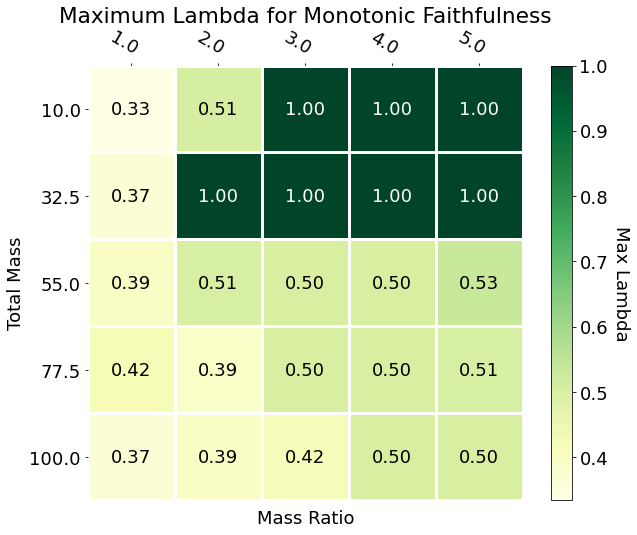

In [85]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 
ax.set_xticks(np.arange(len(qs)), labels=qs)
ax.set_yticks(np.arange(len(Ms)), labels=Ms/lal.MSUN_SI)

im, cbar = heatmap(max_lams, Ms/lal.MSUN_SI, qs, ax=ax,
                   cmap="YlGn", cbarlabel="Max Lambda")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.xlabel("Mass Ratio")
plt.ylabel("Total Mass")

plt.title("Maximum Lambda for Monotonic Faithfulness")
plt.show()



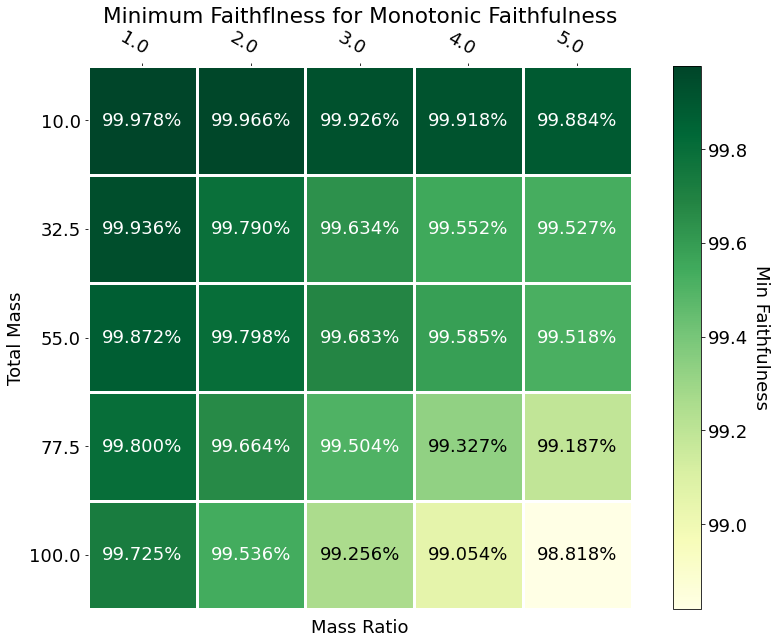

In [87]:
f, ax= plt.subplots(1, 1,  figsize=(15,10)) 
ax.set_xticks(np.arange(len(qs)), labels=qs)
ax.set_yticks(np.arange(len(Ms)), labels=Ms/lal.MSUN_SI)

im, cbar = heatmap(min_faiths*100, Ms/lal.MSUN_SI, qs, ax=ax,
                   cmap="YlGn", cbarlabel="Min Faithfulness")
texts = annotate_heatmap(im, valfmt="{x:.3f}%")

plt.xlabel("Mass Ratio")
plt.ylabel("Total Mass")

plt.title("Minimum Faithflness for Monotonic Faithfulness")
plt.show()

